In [1]:
# PAQUETES PARA CORRER OP.
import numpy as np
import pandas as pd
import datetime as dt
import json
import wmf.wmf as wmf
import hydroeval
import glob
import os
import hidrologia
import SHop

import seaborn as sns
sns.set(style="whitegrid")
sns.set_context('notebook', font_scale=1.13)

#FORMATO
# fuente
import matplotlib
matplotlib.use('Agg')
import matplotlib.font_manager as fm
import pylab as pl 
pl.rc('text',color= '#4f4f4f')

#avoid warnings
import warnings
warnings.filterwarnings('ignore')

No se logra importar basemap, por lo tanto no funciona Plot_basin


In [2]:
# PAQUETES A CORRER EN PLANTILLA.
%matplotlib inline

#### Ejecución horaria.

Nota: Esta ejecución necesita que la ejecución diaria ya este configurada y generando resultados: CId

- Ejecución del modelo y gráficas.

In [3]:
############################################################################################  FECHA
date_ev = pd.to_datetime(dt.datetime.now().strftime('%Y-%m-%d %H')) #pd.to_datetime('2021-03-09 18:00') #

In [30]:
#crear archvios actualizables de HSobs.
# end = date_ev
# path_dfh =  SHop.get_ruta(ConfigList,'ruta_proj')+SHop.get_ruta(ConfigList,'ruta_HSobs_op')
# for esth in df_bd_h.index[:]:
#     print (esth)
#     soilm_df= SHop.query_humedad(esth,'1T',server,user,passwd,dbname,df_bd_h,start=end-pd.Timedelta('10d'),end=end,
#                                 update_or_save_csv=1,path_dfh = path_dfh,calidad=False)

107
118
188
237
235
1004
296
396
422
424
436
455


In [4]:
############################################################################################  ARGUMENTOS
print (dt.datetime.now())

#configfile horario
ruta_proj = '/home/socastillogi/jupyter/git/SHop/'
configfile=ruta_proj+'project_files/inputs/configfile_SHop_E260_90m_1h.md'
save_hist = True ###############################################################False for first times
dateformat_starts_h = '%Y-%m-%d %H'
date_h = pd.to_datetime(date_ev.strftime(dateformat_starts_h))
ConfigList= SHop.get_rutesList(configfile)

#configfile diario
configfile_d=SHop.get_ruta(ConfigList,'ruta_md_d')
ConfigList_d= SHop.get_rutesList(configfile_d)

# abrir simubasin
path_ncbasin = SHop.get_ruta(ConfigList,'ruta_proj')+SHop.get_ruta(ConfigList,'ruta_nc')
cu = wmf.SimuBasin(rute=path_ncbasin)
#sets para correr modelo.
SHop.set_modelsettings(ConfigList)
warming_steps =  5*24 # 5d de wupt #pasos de simulacion no seg, dependen del dt.
warming_window ='%ss'%int(wmf.models.dt * warming_steps) #siempre en seg
dateformat_starts = '%Y-%m-%d %H'
dateformat_binrain = '%Y%m%d%H%M'

#definicion de ventanas
starts  = ['%ss'%(3*24*60*60),'%ss'%(3*24*60*60)] #en seg
starts_names = ['1d']*2  #starts y windows deben ser del mismo len, y coincidir en info
window_end = '%ss'%(1*60*60) #corre la ventana asignada + una hora hacia adelante para agarrar lo que haya de lluvia hasta el momento

#definicion de executionprops
df_executionprops_h = pd.DataFrame([starts,
                                  starts_names,
                                  ['%s-p01-ci1-90d.StOhdr'%(SHop.get_ruta(ConfigList_d,'ruta_proj')+SHop.get_ruta(ConfigList_d,'ruta_sto_op')),
                                  'reglas_pant'],
                                  ['ci2','ci3'],
                                  [[0.8 , 10 , 17.7 , 0.0 , 9.0 , 2.0 , 15 , 0.9 , 1.0 , 1.0, 1.0 ],
                                   [0.8 , 10 , 17.7 , 0.0 , 9.0 , 2.0 , 15 , 0.9 , 1.0 , 1.0, 1.0 ]],
                                  ['-p01','-p01'],
                                  [0,0]], #pasos de sim, depende de dt
                                 columns = [1,2],
                                 index = ['starts','start_names','CIs','CI_names','pars','pars_names','wup_steps']).T

print ('#########################')
print ('Start HOURLY execution: %s'%dt.datetime.now())    
#ventanas de tiempo en que se correra


#dates
start_o = pd.to_datetime(pd.to_datetime(date_h).strftime(dateformat_starts_h))#arranca desde 3d antes pa tener ventana de plot.

starts_w_h = [start_o - pd.Timedelta(start) for start in starts]
starts_m_h = [start_w_h - pd.Timedelta(warming_window) for start_w_h in starts_w_h]
end_h = pd.to_datetime(pd.to_datetime(start_o).strftime(dateformat_starts)) + pd.Timedelta(window_end)

            
#lectura de creds.
server,user,passwd,dbname,user2var,host2var = SHop.get_credentials(SHop.get_ruta(ConfigList,'ruta_proj')+SHop.get_ruta(ConfigList,'ruta_credenciales'))

#consulta x,y estaciones de humedad.
df_xy_est = hidrologia.bd.sql_query('select codigo,longitude,latitude from estaciones where red in ("humedad","humedad_stevens","humedad_laderas_5te_rasp","humedad_stevens_laderas_rasp") and estado in ("A","P")',
                                 server,user,passwd,dbname)
#coordenadas to numeric
df_xy_est = df_xy_est.apply(pd.to_numeric, errors='ignore')
df_xy_estH = df_xy_est.set_index('codigo')
# df_xy_estH = pd.read_csv('df_xy_estH.csv',index_col=0)


# rainfall  : takes 3min
pseries,ruta_out_rain_h = SHop.get_rainfall2sim(ConfigList,cu,path_ncbasin,[starts_m_h[0]],end_h, #se corre el bin mas largo.
                                             Dt= float(wmf.models.dt),include_escenarios=None,
                                             evs_hist= False,
                                             check_file=True,stepback_start = '%ss'%int(wmf.models.dt*1),
                                             complete_naninaccum=True,verbose=False)

print (ruta_out_rain_h)

SHop.set_modelsettings(ConfigList)
# set of executions
ListEjecs_h =  SHop.get_executionlists_fromdf(ConfigList,ruta_out_rain_h,cu,starts_m_h,end_h,df_executionprops_h,
                                         df_xy_estH,warming_steps=warming_steps, 
                                         dateformat_starts = dateformat_starts_h,
                                         path_pant4rules = ruta_out_rain_h)#,fecha_binsto = starts_m_h[0])

# #execution
print ('Start simulations: %s'%dt.datetime.now())
print ('start: %s - end: %s'%(starts_m_h[0], end_h))
SHop.set_modelsettings(ConfigList)
res = SHop.get_qsim(ListEjecs_h[:],set_CI=True,save_hist=save_hist,verbose = True)
print ('End simulations: %s'%dt.datetime.now())
                         
######################################################## GRAFICAS RESULTADOS

################################################# ARGS. GRAFICAS

start = starts_w_h[0]
end= end_h

#METADATOS CAUDAL
estsn = np.array([169, 124, 106, 179, 94, 93, 99, 359, 346, 140]) 
#tramos, para sacar los datos del modelo.
df_est_metadatos = pd.read_csv(SHop.get_ruta(ConfigList,'ruta_proj')+SHop.get_ruta(ConfigList,'ruta_nc_metadatos'),index_col=0)
df_est_metadatos = df_est_metadatos.loc[estsn] #331, 91,342

#otros tramos que neider pidio
df_otrostramos = pd.read_csv(SHop.get_ruta(ConfigList,'ruta_proj')+SHop.get_ruta(ConfigList,'ruta_nc_metadatos_otrostramos'),header=None)
df_otrostramos.columns = ['nombrecauce','tramo']

#METADATOS BD NIVEL
query = "select codigo,nombreestacion,estado,longitude,latitude,offsetn,action_level,minor_flooding,moderate_flooding,major_flooding from estaciones where codigo in %s;"%(str(tuple(['%s'%estn for estn in estsn])))
df_bd_n = hidrologia.bd.sql_query(query,server,user,passwd,dbname).set_index('codigo')
df_bd_n.index = list(map(int,df_bd_n.index)) ; df_bd_n = df_bd_n.loc[estsn];df_bd_n.columns = ['nombreestacion','estado','longitude','latitude','offsetn','n2','n3','n4','n5']
df_bd=df_bd_n.loc[:,'longitude':].apply(pd.to_numeric, errors='coerce')
df_bd[['nombreestacion','estado']] = df_bd_n[['nombreestacion','estado']]
df_bd_n = df_bd.copy()

#MEAN RAINFALL IN EACH BASIN
path_r = ruta_out_rain_h.split('.')[0]+'.hdr'
Dt = '1h'
ests = estsn
path_masks_csv = SHop.get_ruta(ConfigList,'ruta_proj')+SHop.get_ruta(ConfigList,'ruta_csv_subbasinmask')

df_pbasins = SHop.get_pradar_withinnc(path_r,cu,start,end,Dt,ests,path_masks_csv=path_masks_csv)

#METADATOS BD HUMEDAD
estsh = [107,118,188,237,235,1004,296,396,422,424,436,455] #set order for metadata. 
query = 'select codigo, nombreestacion,ciudad,estado,hd,red from estaciones where red in ("humedad","humedad_stevens","humedad_laderas_5te_rasp","humedad_stevens_laderas_rasp") and estado in ("A","P")'
df_bd_h = hidrologia.bd.sql_query(query,server,user,passwd,dbname).set_index('codigo')
df_bd_h.index = list(map(int,df_bd_h.index)) ; df_bd_h = df_bd_h.loc[estsh]
df_bd_h.columns = ['nombreestacion', 'ciudad', 'estado', 'tipo_sensor', 'red']
df_bd_h.tipo_sensor = list(map(int,df_bd_h.tipo_sensor.values))
estsh = list(df_bd_h.index)

#asignaciones
codigos_pluvio = np.array([20,288,189,25,43,57,295,43,295,389,373,418])
#si en la consulta hay mas filas que pluvio, se descartan las filas que excden el size. puede que haya una estacion nueva y no nos hayan contado.
#No se grafica hasta que se tengan todos los metadatos, 
if df_bd_h.shape[0]>codigos_pluvio.size:
    print('Warning: Possibly there are more stations than pluviometers assigned. %s vs. %s'%(df_bd_h.shape[0],codigos_pluvio.size))
    df_bd_h = df_bd_h.loc[df_bd_h.index[:codigos_pluvio.size]]

else:
    pass


df_bd_h[['p_asociado','sensor_h','depths2drop','depths_laderas']] = pd.DataFrame([codigos_pluvio,
                                                                       [[1,2,3],[1,3],[2,3],[2],[1,2,3],[1,2,3],[1,2],[1,2,3],[1,2,3],[1,2],[1],[1,2]],
                                                          np.array([None,[2],[1],[1,3],None,[3],None,None,None,[3],[2,3],[3]]),
                                                          np.array([None,None,None,None,None,None,None,None,None,['1','1.2'],['1.36'],['0.5','1']])],
                                                          columns=df_bd_h.index, 
                                                          index = ['p_asociado','sensor_h','depths2drop','depths_laderas']).T


# POINT RAINFALL IN ESTS_H: kernel 3x3
estsh = list(df_xy_estH.index)
df_pestsH = SHop.get_pradar_withinnc(path_r,cu,start,end,Dt,estsh,df_points = df_xy_estH)

#SET FONTPROPS
ruta_fuentes= SHop.get_ruta(ConfigList,'ruta_fuente')
SHop.set_fontprops(ruta_fuentes)


######################################### CONSULTA NOBS. estaciones validacion
Dt = '%ss'%(int(wmf.models.dt))
ruta_nobs = SHop.get_ruta(ConfigList,'ruta_proj')+SHop.get_ruta(ConfigList,'ruta_nobs_op')
ruta_qobs = SHop.get_ruta(ConfigList,'ruta_proj')+SHop.get_ruta(ConfigList,'ruta_qobs_op')

df_nobs,df_qobs = SHop.consulta_nyqobs(estsn,start,end,server,user,passwd,dbname,Dt,
                                  df_est_metadatos,ruta_qobs,ruta_nobs,save_hist=False)

########################################## GRAFICAS CAUDAL estaciones validacion
colors_q = ['c','darkblue'] ; ylims_q = np.array([10,20,40,40,100,100,300,200,200,200])
rutafig = SHop.get_ruta(ConfigList,'ruta_proj')+SHop.get_ruta(ConfigList,'ruta_qsim_png')

SHop.plot_Q(estsn,ylims_q,ListEjecs_h,colors_q,df_est_metadatos,df_bd_n,df_qobs,df_pbasins,rutafig = rutafig)

########################################## GRAFICAS CAUDAL - otros tramos 
colors = ['c','darkblue']
rutafig = SHop.get_ruta(ConfigList,'ruta_proj')+SHop.get_ruta(ConfigList,'ruta_qsim_png')
names_otrostramos = []
for name in df_otrostramos.nombrecauce.values: 
    if len(name.split(' ')) > 2: names_otrostramos.append(''.join(name.split(' ')[-2:])) 
    else: names_otrostramos.append(name.split(' ')[-1:][0])
df_otrostramos['id'] = names_otrostramos

SHop.plot_Qotros(df_otrostramos,ListEjecs_h,colors,rutafig=rutafig)

########################################## GRAFICAS NIVEL est. validacion
rutafig = SHop.get_ruta(ConfigList,'ruta_proj')+SHop.get_ruta(ConfigList,'ruta_nsim_png')
colors_n = ['lightgreen','g'] ; ylims_n = ylims_q/10.
SHop.plot_N(estsn,ylims_n,ListEjecs_h,colors_n,df_est_metadatos,df_bd_n,df_nobs,df_pbasins,rutafig=rutafig)

########################################## GRAFICAS HUMEDAD estaciones
rutafig = SHop.get_ruta(ConfigList,'ruta_proj')+SHop.get_ruta(ConfigList,'ruta_hs_sim_png')
colors_sim = [(0.7114648212226067, 0.801276432141484, 0.8883044982698962, 1.0),
              (0.5490196078431373, 0.49036524413687044, 0.7286735870818916, 1.0)]

#NOTA: correr el query_humedad guardando los datos historicos antes de poner operativo este.
path_dfh =  SHop.get_ruta(ConfigList,'ruta_proj')+SHop.get_ruta(ConfigList,'ruta_HSobs_op')
# for esth in df_bd_h.index[:]:
#     print (esth)
#     soilm_df= query_humedad(esth,'1T',server,user,passwd,dbname,df_bd_h,start=start,end=end,
#                                 update_or_save_csv=1,path_dfh = path_dfh,calidad=False)

SHop.plotHS(df_bd_h,start,end,ListEjecs_h,colors_sim,df_est_metadatos,df_pestsH,
       server,user,passwd,dbname,path_dfh,Dt,rutafig= rutafig)

########################################## GRAFICAS HUMEDAD MAPAS porc_sat y hg_log
chosen_L = ListEjecs_h[0]
ruta_map_hglog = '%s%s%s'%(SHop.get_ruta(ConfigList,'ruta_proj'),SHop.get_ruta(ConfigList,'ruta_hglog_sim_png'),'hglog.png')
ruta_map_psat = '%s%s%s'%(SHop.get_ruta(ConfigList,'ruta_proj'),SHop.get_ruta(ConfigList,'ruta_hglog_sim_png'),'porcsat.png')
ruta_map_psats = SHop.get_ruta(ConfigList,'ruta_proj')+SHop.get_ruta(ConfigList,'ruta_psat_sim_2gif')
ruta_map_hglogs = SHop.get_ruta(ConfigList,'ruta_proj')+SHop.get_ruta(ConfigList,'ruta_hglog_sim_2gif')
ruta_mapas_sim_sal = SHop.get_ruta(ConfigList,'ruta_mapas_sim_sal')

SHop.plot_mapas_HS(chosen_L,ruta_map_hglog, ruta_map_psat,ruta_map_hglogs,ruta_map_psats,
                   user2var,host2var,ruta_mapas_sim_sal)


########################################## COPIAR FIGS AL VAR/WWW
#ls -al ~/.ssh/id_*.pub #chekear key
# ssh-keygen -t rsa #crear key #responder preguntas con enter y ya.
# ssh-copy-id remote_username@remote_IP_Address

ruta_var = '%s@%s:/var/www/hidrologia/SH_op/graficas_op/'%(user2var,host2var)
ruta_graficas = SHop.get_ruta(ConfigList,'ruta_proj')+SHop.get_ruta(ConfigList,'ruta_graficas_resultados')

res = os.system('rsync -r -v -a -z -e ssh --exclude={"%s","%s"} %s* %s'%('humedaddelsuelo/mapas/psat','humedaddelsuelo/mapas/hglog',ruta_graficas, ruta_var))
if res == 0:
    print ('Se copian archivos en %s'%(ruta_var))
else:
    print ('No se copian archivos en %s'%(ruta_var))
    
    
############################################################# KML
g1 = '''<Placemark>
<styleUrl>#testIcon197</styleUrl>
<name>{0}</name>
<ExtendedData><SchemaData schemaUrl="#Humedad_new">
    <SimpleData name="Codigo">{1}</SimpleData>
    <SimpleData name="Municipio">{2}</SimpleData>
    <SimpleData name="Latitud">{3}</SimpleData>
    <SimpleData name="Longitud">{4}</SimpleData>
    <SimpleData name="icon">{7}</SimpleData>
    <SimpleData name="info">Los sensores de humedad del suelo miden el contenido volumétrico de agua en el suelo (CVA), es decir, la proporción [%] entre el volumen de agua y el volumen total de una esfera de suelo (alcance del sensor). Sus datos los llamamos observaciones (obs.), son información puntual, particular del lugar de instalación. Las observaciones cambian con variables como: la precipitación en el punto (que medimos con pluviómetros) y la profundidad de instalación de cada sensor. De hecho, en algunas estaciones hay varios sensores instalados a diferente profundidad.\n Por otro lado, el modelo hidrológico simula el CVA promedio de todo un perfil de suelo, independiente de la profundidad. Estos datos los llamamos simulaciones (sim.) y para obtenerlos se realizáron ejecuciones del modelo a partir de la precipitación derivada del radar meteorológico. \nDadas las variaciones entre la información observada y simulada, es preciso aclarar que esta figura siempre compara la humedad simulada (CVA_sim) respecto a las observaciones (CVA_obs) del sensor de humedad más superficial de cada estación. Además, siempre muestra la precipitación medida por pluviómetros y por radar para permitir una mejor comparación de los datos.</SimpleData>
    <SimpleData name="fecha_ultima_actualizacion">{5}</SimpleData>
    <SimpleData name="G_3_H_CVA">{6}</SimpleData>
</SchemaData></ExtendedData>
    <Point><coordinates>{4},{3}</coordinates></Point>
</Placemark>
'''

blocks = []
path_figs = 'http://siata.gov.co/hidrologia/SH_op/graficas_op/humedaddelsuelo/estaciones/'
path_kml_format = SHop.get_ruta(ConfigList,'ruta_proj')+SHop.get_ruta(ConfigList,'ruta_kmlhumedad_formato')
path_kml = SHop.get_ruta(ConfigList,'ruta_proj')+SHop.get_ruta(ConfigList,'ruta_kmlhumedad_geoportal')
url_icono = SHop.get_ruta(ConfigList,'ruta_kmlhumedad_icono')
df_bd_h[['longitude','latitude']] = df_xy_estH
df_metadata = df_bd_h.copy()
print (df_metadata.estado)

###################################################ejecucion
kml = SHop.write_kml_humedad(df_metadata.index,df_bd_h,path_figs,path_kml_format,path_kml,g1,url_icono)
ruta_var_kml = '%s@%s:/var/www/kml/01_Redes/'%(user2var,host2var)

# res = os.system('scp -r %s %s'%(path_kml, ruta_var_kml))
res = os.system('rsync -r -v -a -z -e ssh %s %s'%(path_kml, ruta_var_kml))
if res == 0:
    print ('Se copia kml en %s'%(ruta_var_kml))
else:
    print ('No se copia kml en %s'%(ruta_var_kml))
      
print (dt.datetime.now())

2021-03-12 21:04:09.303338
#########################
Start HOURLY execution: 2021-03-12 21:04:09.405473
SERVER_CON: Succesful connection to Sal
error - no field found 
.bin & .hdr saved
/home/socastillogi/jupyter/git/SHop/project_files/results/results_op/rain_op/202103042000_202103122200-SHop_E260_90m_1h.bin
Start simulations: 2021-03-12 21:06:34.807277
start: 2021-03-04 21:00:00 - end: 2021-03-12 22:00:00
Config. -p01ci2-/home/socastillogi/jupyter/git/SHop/project_files/results/results_h/Qsim_hist-p01-ci2-1d.csv ejecutado
Config. -p01ci3-/home/socastillogi/jupyter/git/SHop/project_files/results/results_h/Qsim_hist-p01-ci3-1d.csv ejecutado
End simulations: 2021-03-12 21:06:43.585322
Consulta exitosa de Nobs
Graphics are generated: Qval
Graphics are generated: Qotros
Graphics are generated: Nval
Graphics are generated: HS
Graphics are generated: maps HS.
Se copian mapas para hist en: /home/socastillogi/jupyter/git/SHop/project_files/results/graficas/humedaddelsuelo/mapas/hglog/
Se copia

In [20]:
print('hourly execution takes: %s seg.'%(4*60.))

hourly execution takes: 240.0 seg.


<AxesSubplot:xlabel=' Fecha '>

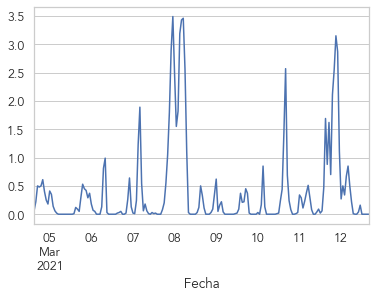

In [6]:
# checkear que lluvia este normi y no en cero.
df_st = wmf.read_rain_struct(ruta_out_rain_h.split('.')[0]+'.hdr')
df_st[' Lluvia'].plot()

- Nota: Revisar las gráficas operativas para verificar que todo esté funcionando correctamente

#### escribir 1eras  imágenes humedad para histórico

In [48]:
#configfile horario
ruta_proj = '/home/socastillogi/jupyter/git/SHop/'
configfile=ruta_proj+'project_files/inputs/configfile_SHop_E260_90m_1h.md'
save_hist = True ###############################################################False for first times
dateformat_starts_h = '%Y-%m-%d %H'
date_h = pd.to_datetime(date_ev.strftime(dateformat_starts_h))
ConfigList= SHop.get_rutesList(configfile)

In [42]:
L = ListEjecs_h[0]
ruta_map_hglog
ruta_map_porcsat

ruta_map_psats = SHop.get_ruta(ConfigList,'ruta_proj')+SHop.get_ruta(ConfigList,'ruta_psat_sim_2gif')
ruta_map_hglogs = SHop.get_ruta(ConfigList,'ruta_proj')+SHop.get_ruta(ConfigList,'ruta_hglog_sim_2gif')
# ruta_map_psats_sal = SHop.get_ruta(ConfigList,'ruta_proj')+SHop.get_ruta(ConfigList,'ruta_psat_sim_2gif_sal')
# ruta_map_hglogs_sal = SHop.get_ruta(ConfigList,'ruta_proj')+SHop.get_ruta(ConfigList,'ruta_hglog_sim_2gif_sal')

- escribir imagenes de ultimos 3d la primera vez, luego ,a otra función lo actualizará

In [ ]:
# def plot_mapas_HS(L,ruta_map_hglog, ruta_map_porcsat):
    
cu = L[0]
f=open(L[9]+'.StOhdr')
filelines=f.readlines()
f.close()
IDs= np.array([int(i.split(',')[0]) for i in filelines[5:]])
fechas= pd.to_datetime(np.array([i.split(',')[-1].split(' ')[1] for i in filelines[5:]]))

ini = fechas.get_loc(start) #pos of wupt.
for ID,fecha in zip(IDs[ini:],fechas[ini:]):
    #lee almacenamientos
    v,r = wmf.models.read_float_basin_ncol(L[9]+'.StObin',ID, cu.ncells, 5)
    v[2][v[2]> wmf.models.max_gravita[0]] = wmf.models.max_gravita[0][v[2]> wmf.models.max_gravita[0]] #sumideros?

    #hg_mm log
    bounds = np.arange(0,8,1); #tickslabels = np.array([int(np.round(math.exp(i))) for i in bounds])
    tickslabels = np.array([1,20,80,150,420]); ticks = np.log(tickslabels)
    cbar = "YlGnBu"; cmap,norm = SHop.get_intervalcmap(bounds,cbar)
    cu.Plot_basinClean(np.log(v[2]), cmap= pl.get_cmap(cbar),show_cbar= False,
                       cbar_ticks= ticks,
                       cbar_ticklabels= tickslabels,
                       figsize=(15,20), #dpi=120,
                       ruta= '%s%s'%(ruta_map_hglogs,fecha.strftime('%Y%m%d%H%M')))
    pl.close()

    #hu+hg sat
    bounds = np.arange(0,100,10); cbar = 'BuPu' ; cmap,norm = SHop.get_intervalcmap(bounds,cbar)
    porc_sat = ((v[0]+v[2])/(wmf.models.max_capilar+wmf.models.max_gravita))*100
    cu.Plot_basinClean(porc_sat, cmap= pl.get_cmap(cbar),show_cbar= False,
                       cbar_ticks= bounds,
    #                    cbar_ticklabels= tickslabels,
                       figsize=(15,20), #dpi=120,
                       ruta= '%s%s'%(ruta_map_psats,fecha.strftime('%Y%m%d%H%M')))
    pl.close()
    # print('Graphics are generated: maps HS.')

In [6]:
# res = os.system('rsync -avz /home/socastillogi/jupyter/git/SHop/project_files/results/graficas/humedaddelsuelo/mapas user2var@host2var:/var/www/data/modelo_hidrologico_op/humedaddelsuelo/')
# res

5888